### Esercitazione 4

### Dinamica molecolare

In questo esercizio si studia la distribuzione delle velocità delle particelle in un gas rarefatto attraverso simulazioni di dinamica molecolare (MD), utilizzando il modello di Lennard-Jones. Lo scopo è osservare l’evoluzione del sistema verso l’equilibrio termodinamico e confrontare la distribuzione delle velocità ottenuta numericamente con la distribuzione teorica di Maxwell–Boltzmann.

### Distribuzione di Maxwell–Boltzmann

La distribuzione di Maxwell–Boltzmann descrive la probabilità di trovare particelle a una certa velocità $ v$ in un gas ideale in 3 dimensioni. In unità ridotte di Lennard-Jones, la distribuzione diventa:

$p(v^*,T^*) = \frac{1}{(2\pi T^*)^{3/2}} 4\pi (v^*)^2 e^{-\frac{(v^*)^2}{2 T^*}}$

In questa simulazione, è stata implementata all’interno del codice la stima numerica della distribuzione $ p(v^*,T^*)$ mediante **istogramma normalizzato** su un intervallo $[0, v_{\text{max}}]$, suddiviso in un numero fissato di bin.

### Da una Delta di Dirac ad una Maxwell Boltzmann

Si esegue una simulazione di dinamica molecolare utilizzando il **potenziale di Lennard-Jones** con i seguenti parametri:
- $n=108$ Particelle
- $\delta=0.001$
- $\rho^\star=0.05$
- Raggio di cut-off $r_c = 5.0$
- $T^\star \sim 2.0$

Si sceglie una configurazione iniziale del sistema a bassa entropia:
  - Le **posizioni** iniziali delle particelle sono disposte su un reticolo fcc che occupa solo metà del box in ogni direzione.
  - Le **velocità** iniziali sono assegnate tramite una distribuzione a delta di Dirac:
    $p_\delta(v^*,T^*) = \delta\left( v^* - v_{T^*} \right)$
    dove $v_{T^*}$ è calcolata in base alla temperatura ridotta, assegnando velocità $\pm v_{T^*}$ a **una sola** componente per particella $v_x$, $v_y$ o $v_z$.

**Scopo dell’esperimento**:
- Dimostrare che l’evoluzione del sistema dove le velocità sono distribuite secondo la Delta tendono a convergere verso la distribuzione di Maxwell–Boltzmann.

L’energia totale è conservata nella simulazione MD, ma la temperatura e l’energia cinetica non lo sono. Il confronto teorico è stato fatto con $p(v^*, T^*_{\text{eff}})$, dove $ T^*_{\text{eff}}$ è la temperatura effettiva raggiunta dopo l’equilibratura del sistema.
Per la simulazione sono stati usati $N=10000$ blocchi da $M=5$ step ciascuno.



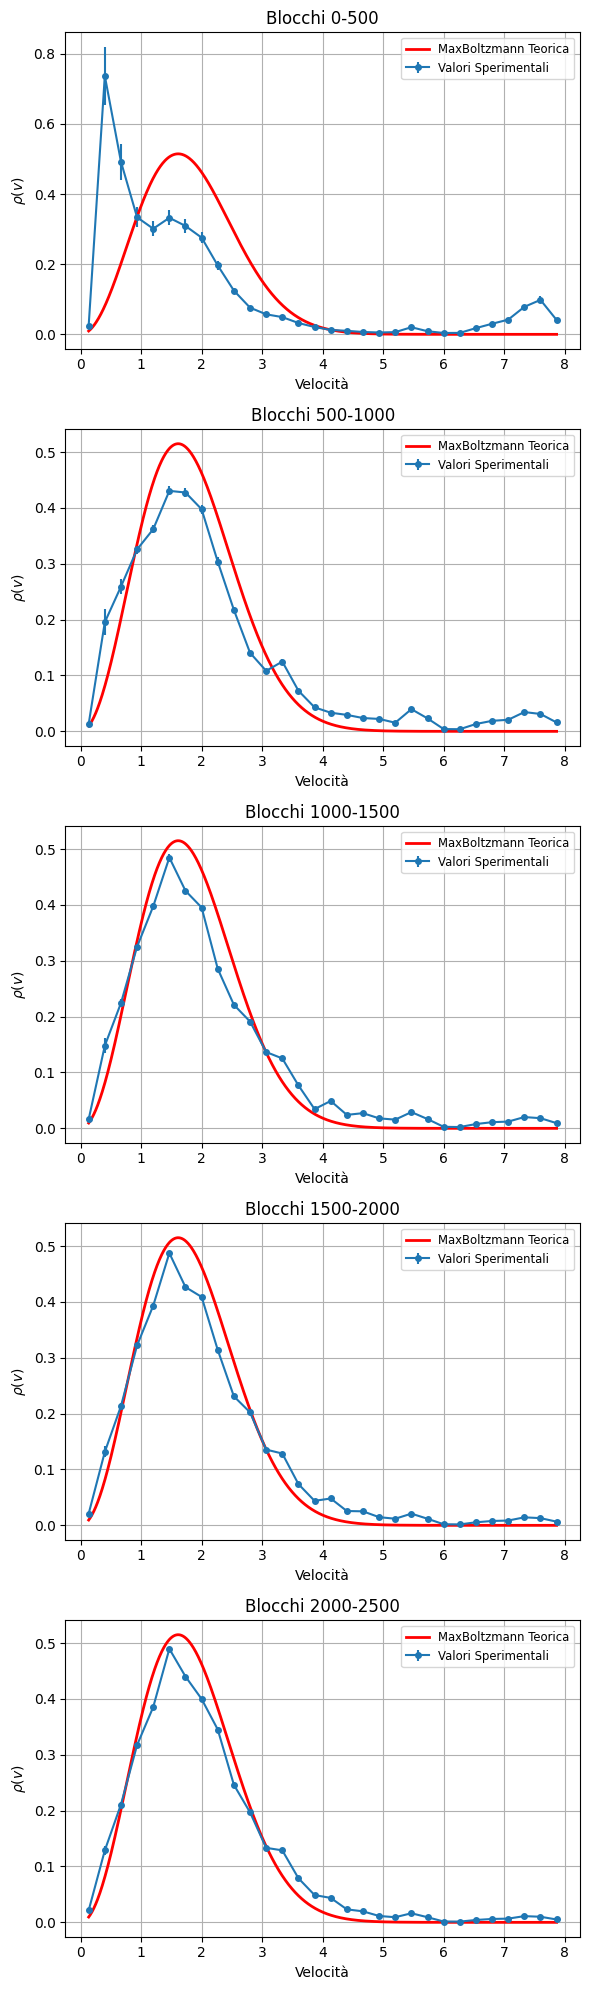

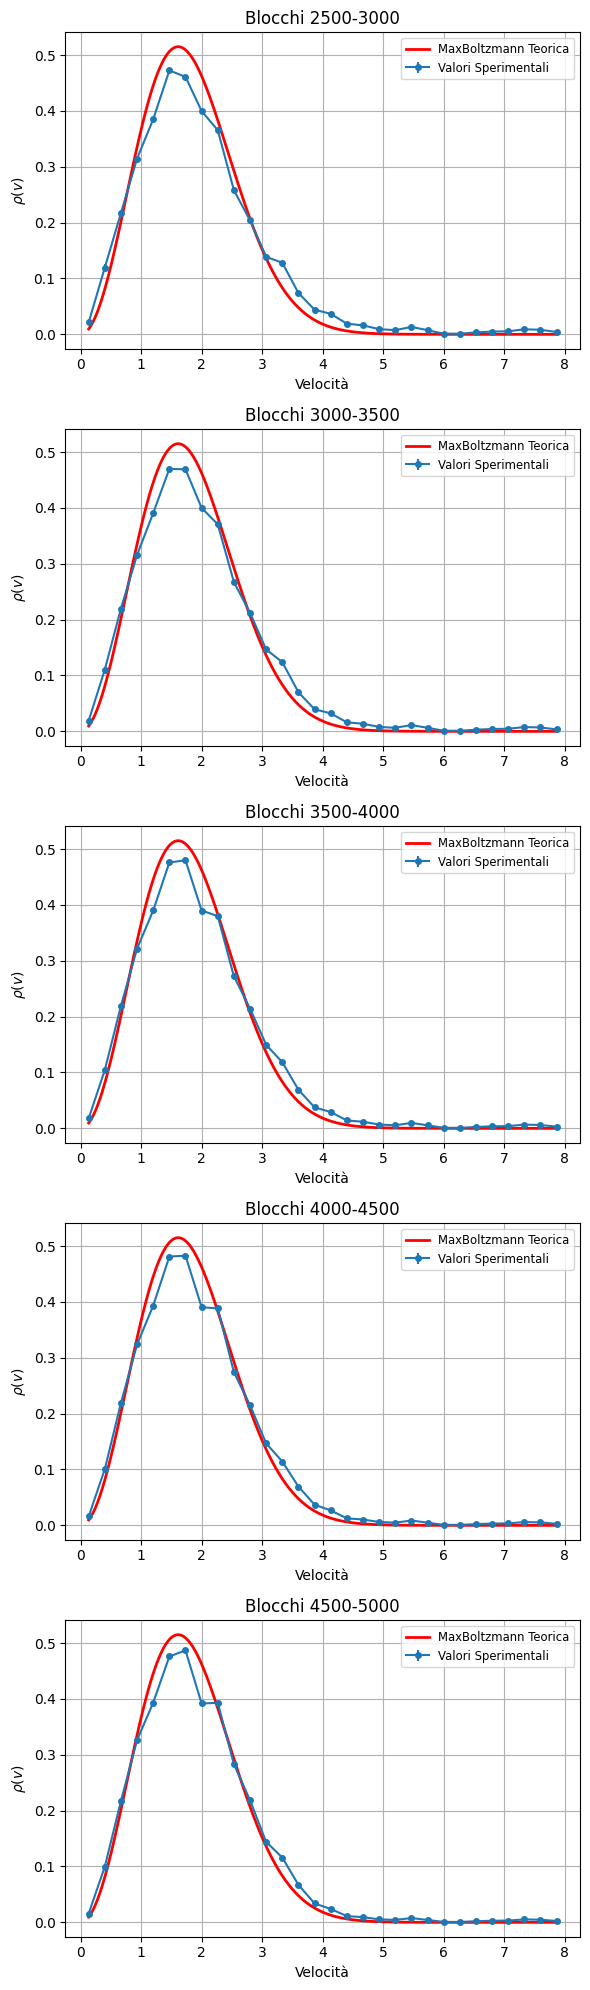

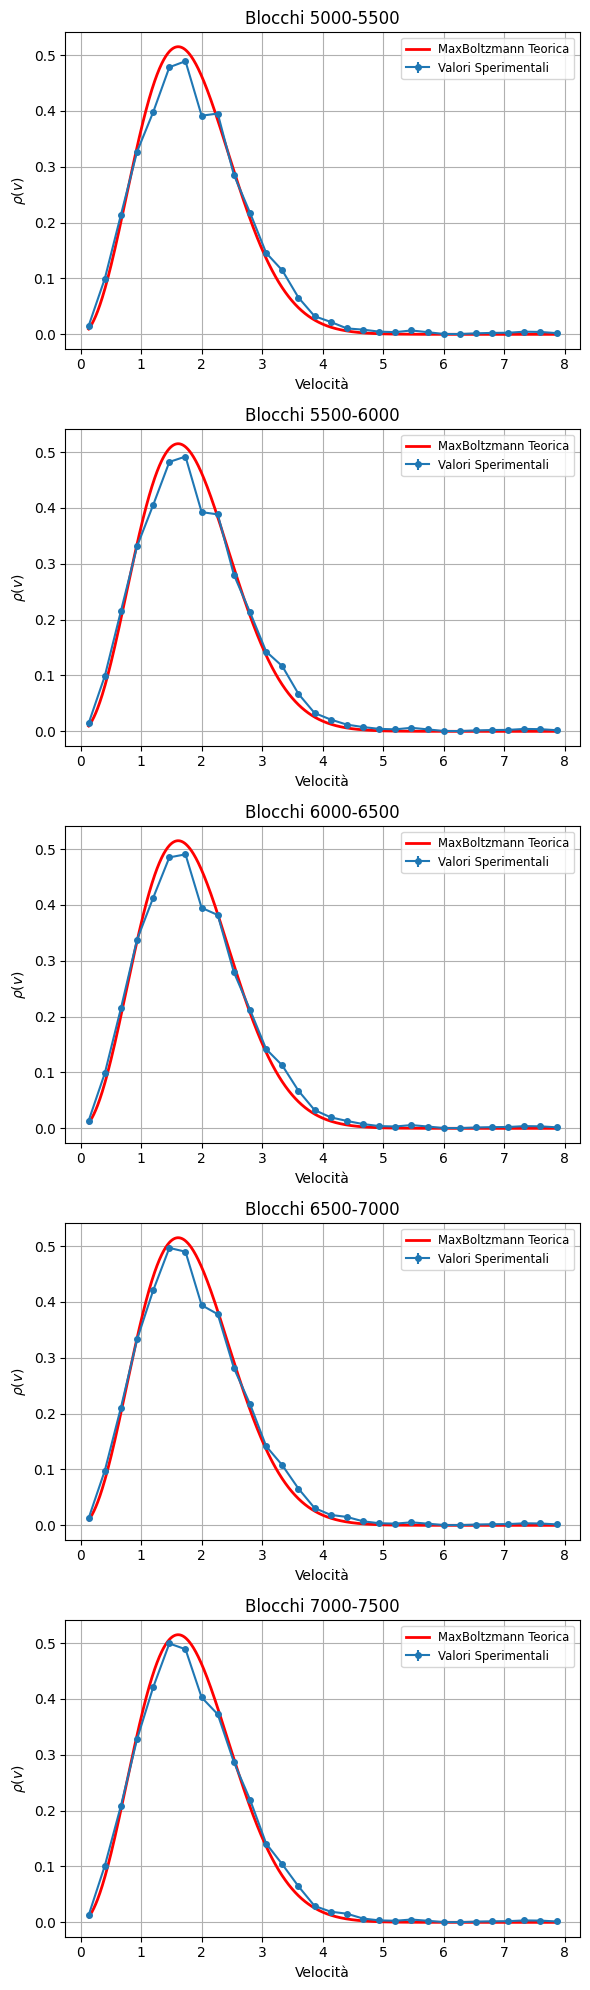

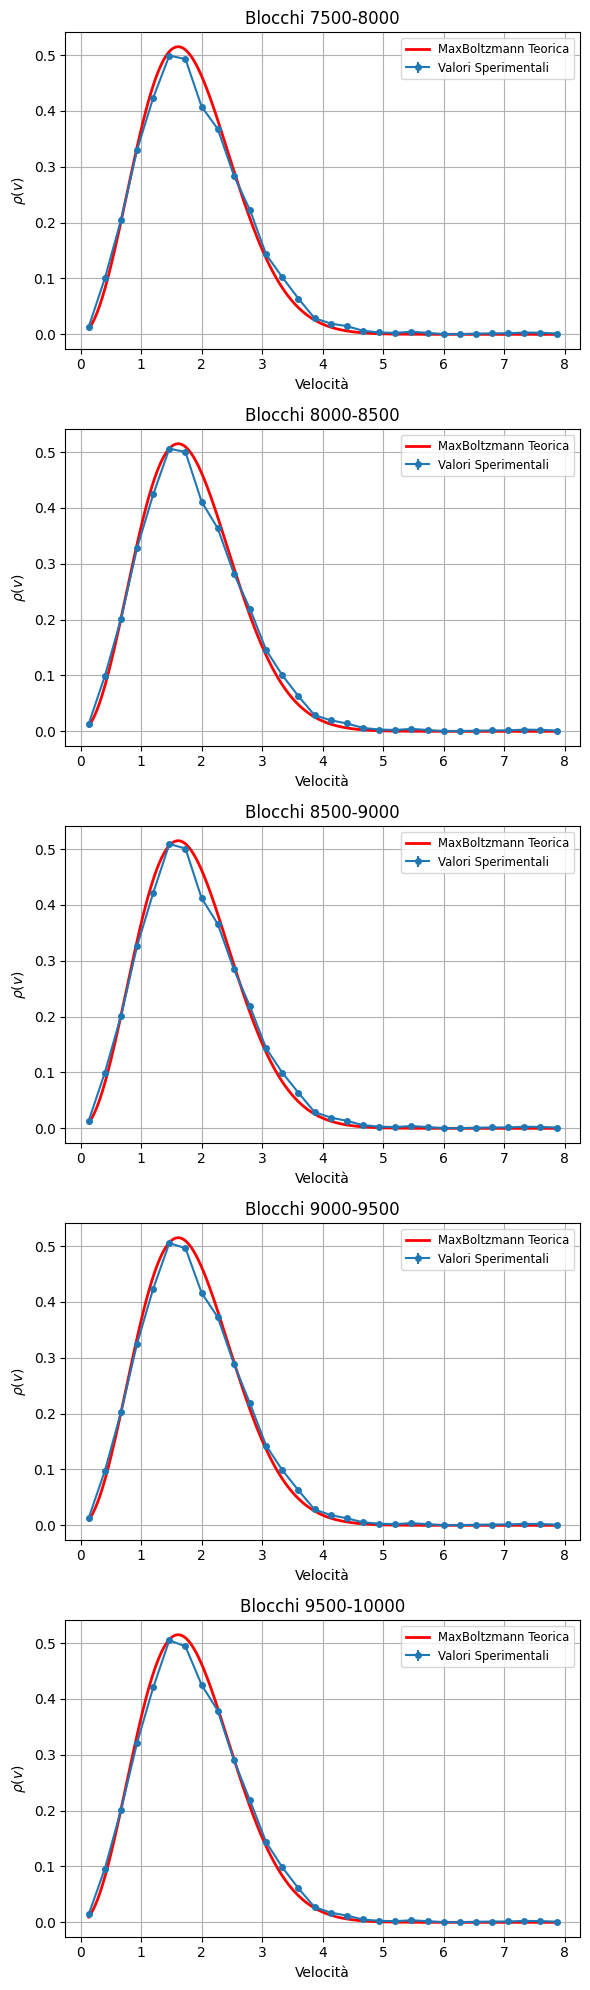

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import maxwell
import os

dati = np.loadtxt("pofv.dat", skiprows=1)
vel = dati[:,0]
pofv = dati[:,1]
err = dati[:,2]

n_bins = 30
n_blocchi = len(vel) // n_bins  
blocchi_per_fig = int(n_blocchi/4)
blocchi_per_subplot = int(blocchi_per_fig/5)
subplots_per_fig = blocchi_per_fig // blocchi_per_subplot

v_theory = np.linspace(min(vel), max(vel), 1000)
mb_dist = maxwell.pdf(v_theory, scale=np.sqrt(1.3))

for fig_num in range(4):  
    fig, axs = plt.subplots(subplots_per_fig, 1, figsize=(6, 4 * subplots_per_fig))

    for subplot_num in range(subplots_per_fig):
        start_block = fig_num * blocchi_per_fig + subplot_num * blocchi_per_subplot
        end_block = start_block + blocchi_per_subplot

        if start_block >= n_blocchi:
            continue

        v_medio = np.zeros(n_bins)
        p_medio = np.zeros(n_bins)
        e_medio = np.zeros(n_bins)

        valid_blocks = 0

        for b in range(start_block, min(end_block, n_blocchi)):
            idx = b * n_bins
            v_medio += vel[idx:idx + n_bins]
            p_medio += pofv[idx:idx + n_bins]
            e_medio += err[idx:idx + n_bins] ** 2  

            valid_blocks += 1

        v_medio /= valid_blocks
        p_medio /= valid_blocks
        e_medio = np.sqrt(e_medio) / valid_blocks

        # Normalizzazione
        delta_v = np.mean(np.diff(v_medio))
        norm_factor = np.sum(p_medio * delta_v)
        if norm_factor > 0:
            p_medio /= norm_factor

        # Plot
        ax = axs[subplot_num]
        ax.errorbar(v_medio, p_medio, yerr=e_medio, fmt='o-', markersize=4,
                    label='Valori Sperimentali')
        ax.plot(v_theory, mb_dist, 'r-', lw=2, label='MaxBoltzmann Teorica')
        ax.set_title(f'Blocchi {start_block}-{end_block}')
        ax.set_xlabel('Velocità')
        ax.set_ylabel(r'$\rho(v)$')
        ax.legend(fontsize='small')
        ax.grid()

    plt.tight_layout()
    plt.show()
    plt.close()


### Reversibilità temporale

A partire dallo stato finale di equilibrio ottenuto nella simulazione precedente, si studia la possibilità di **tornare alla configurazione a bassa entropia iniziale** invertendo la direzione del tempo.

**Procedura**:
- Si usa la configurazione finale della vecchia simulazione come configurazione 0 e la penultima come prima configurazione 1
- Si fa evolvere nuovamente il sistema nel tempo.

Teoricamente il sistema dovrebbe tornare esattamente alla configurazione di partenza in quanto il moto è deterministico.
Nella prartica tutto ciò è impossibile a causa di minime cifre decimali diverse dalla precedente simulazione che causano nel lungo periodo un cambiamento nel percorso intrapreso dalle particelle, creando a loro volta una nuova configurazione.

Questo è dovuto alla legge dei moti caotici.

Qui di seguito si mostrano i grafici dell' energia potenziale e della tempratura nella prima simulazione e in quella reverse.


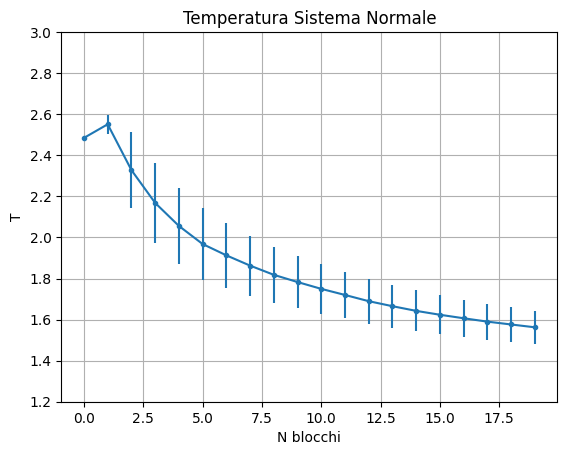

In [65]:
dati2=np.loadtxt("temperatureN.dat",skiprows=1)

T=dati2[:,2]
errT=dati2[:,3]
n_blocchi=20
plt.errorbar(range(n_blocchi),T,yerr=errT,fmt="o-", markersize=3)
plt.grid()
plt.ylim(1.2,3)
plt.title("Temperatura Sistema Normale")
plt.xlabel("N blocchi")
plt.ylabel("T")
plt.show()
plt.close()

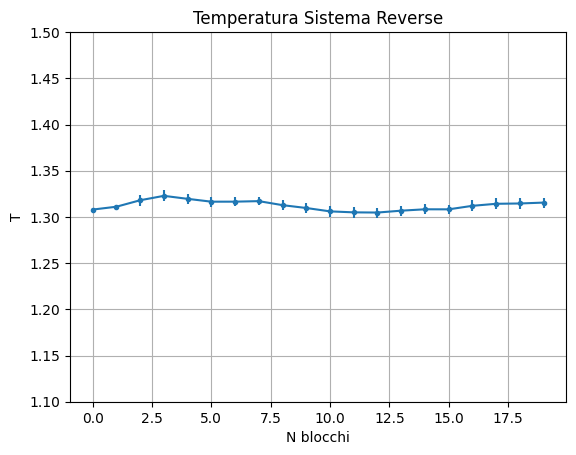

In [69]:
dati2=np.loadtxt("temperatureR.dat",skiprows=1)

T=dati2[:,2]
errT=dati2[:,3]
n_blocchi=20
plt.errorbar(range(n_blocchi),T,yerr=errT,fmt="o-", markersize=3)
plt.grid()
plt.ylim(1.1,1.5)
plt.title("Temperatura Sistema Reverse")
plt.xlabel("N blocchi")
plt.ylabel("T")
plt.show()
plt.close()

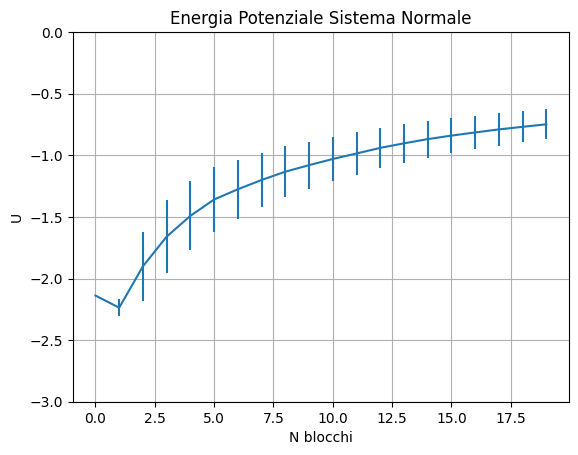

In [70]:
dati3=np.loadtxt("potential_energyN.dat",skiprows=1)

U=dati3[:,2]
errU=dati3[:,3]

plt.errorbar(range(n_blocchi),U,yerr=errU)
plt.grid()
plt.title("Energia Potenziale Sistema Normale")
plt.xlabel("N blocchi")
plt.ylabel("U")
plt.ylim(-3,0)
plt.show()
plt.close()

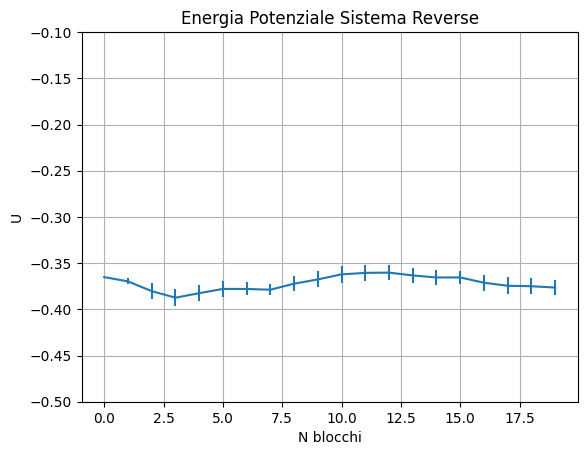

In [72]:
dati3=np.loadtxt("potential_energyR.dat",skiprows=1)

U=dati3[:,2]
errU=dati3[:,3]

plt.errorbar(range(n_blocchi),U,yerr=errU)
plt.grid()
plt.title("Energia Potenziale Sistema Reverse")
plt.xlabel("N blocchi")
plt.ylabel("U")
plt.ylim(-0.5,-0.1)
plt.show()
plt.close()